In [47]:
import random

from qutip import *
from qiskit.visualization import array_to_latex
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import chisquare

# 1)

## 1.A)

<ErrorbarContainer object of 3 artists>

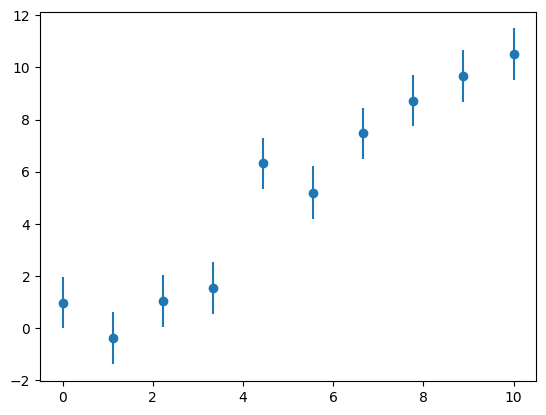

In [61]:
slope = 1
offset = 0.25
time = np.linspace(0,10,10)
data = np.random.normal(slope*time + offset,1)
sigma = 1*np.random.normal(np.ones(len(data)),0.01)

plt.errorbar(time,data,yerr=sigma,fmt='o')

## 1.B)

First, lets take a look at the linear fit

In [62]:
def func_linear(x, a, b):
    return a*x + b

In [63]:
lin_fit = curve_fit(func_linear, time, data, sigma=sigma)
print("Linear fit parameters: a={:0.4f}, b={:0.4f}".format(lin_fit[0][0], lin_fit[0][1]))

Linear fit parameters: a=1.1479, b=-0.6148


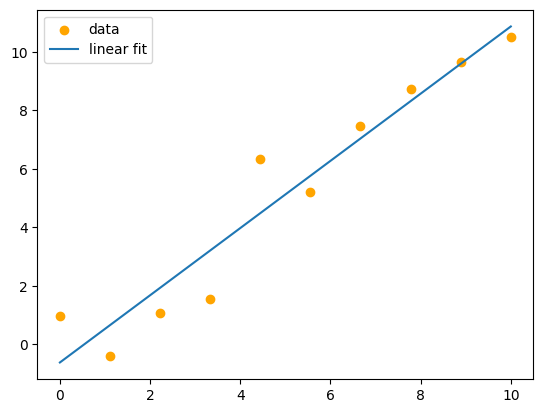

In [64]:
plt.scatter(time, data, label='data', color='orange')
plt.plot(time, func_linear(time, *lin_fit[0]), label='linear fit')
plt.legend()
plt.show()

Next, lets take a look at the quadtatic fit.

In [65]:
def func_quadratic(x, a, b, c):
    return a * x**2 + b * x + c

In [66]:
quad_fit = curve_fit(func_quadratic, time, data, sigma=sigma)
print("Quadratic fit parameters: a={:0.4f}, b={:0.4f}, c={:0.4f}".format(quad_fit[0][0], quad_fit[0][1], quad_fit[0][2]))

Quadratic fit parameters: a=0.0135, b=1.0132, c=-0.4167


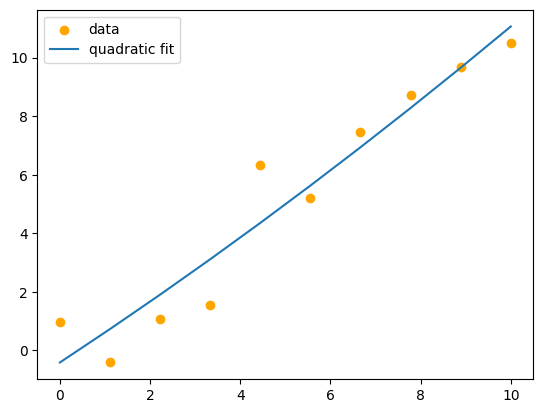

In [67]:
plt.scatter(time, data, label='data', color='orange')
plt.plot(time, func_quadratic(time, *quad_fit[0]), label='quadratic fit')
plt.legend()
plt.show()

# 1.C)

In [68]:
def chi_squared(data, model, sigma):
    sum = 0
    for i in range(len(data)):
        sum += ((data[i] - model[i])/sigma[i])**2
    return sum

In [69]:
chi_square_linear = chi_squared(data, func_linear(time, *lin_fit[0]), sigma)
v_linear = len(data) - len(lin_fit[0])
print(v_linear)
print("X^2 / V for linear fit: {:0.4f}".format(chi_square_linear/v_linear))

8
X^2 / V for linear fit: 1.4412


In [70]:
chi_square_quadratic = chi_squared(data, func_quadratic(time, *quad_fit[0]), sigma)
v_quadratic = len(data) - len(quad_fit[0])
print(v_quadratic)
print("X^2 / V for quadratic fit: {:0.4f}".format(chi_square_quadratic/v_quadratic))

7
X^2 / V for quadratic fit: 1.6257


Therefore, we can conclude that the linear fit is slightly better for fitting this data than the quadratic

# 3)

## 3.A)

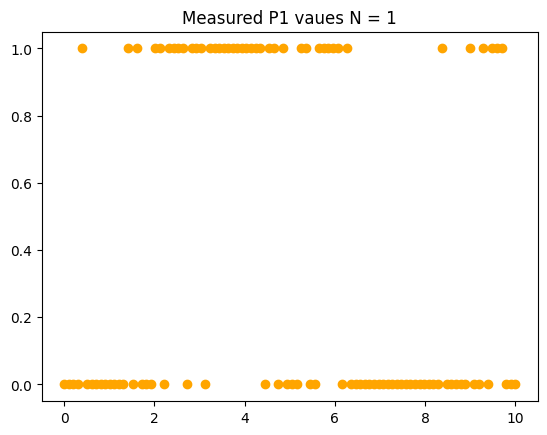

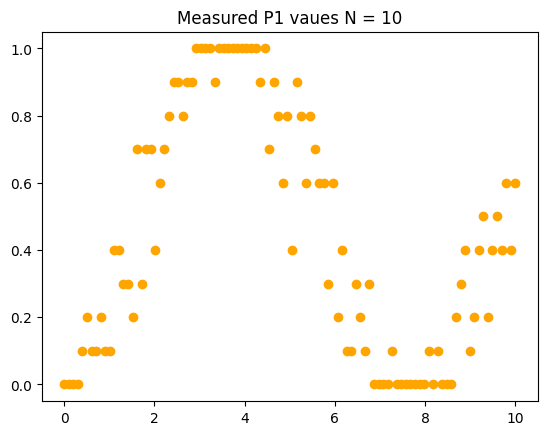

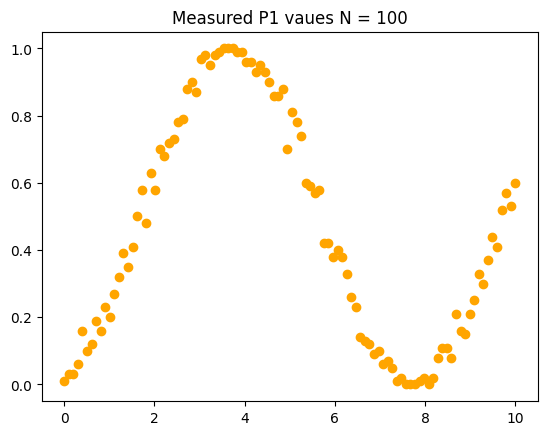

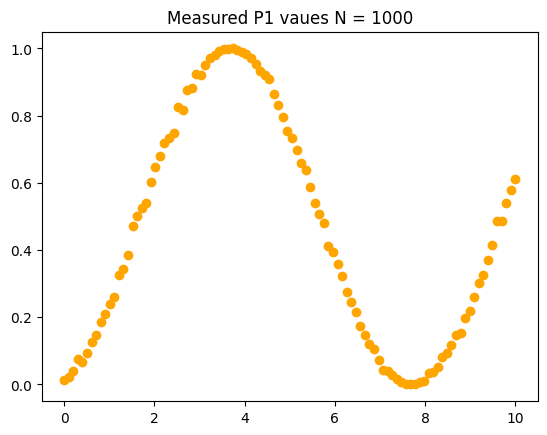

In [2]:
t_p = 1
delta = np.pi / 4
Omega = 2 * np.pi

def P1(t_w, Omega, delta):
    Omega_p = np.sqrt(Omega**2 + delta**2)
    return 1 - (Omega**2) / (Omega_p**4) * (Omega_p * np.cos(delta * t_w / 2) * np.sin(np.pi/2) - 2 * delta * np.sin(delta * t_w / 2) * np.sin(np.pi/4)**2 )**2


for N in [1, 10, 100, 1000]:
    t_w = np.linspace(0, 10, 100)
    measured_results = []
    for t in t_w:
        true_p1 = P1(t, Omega, delta)
        p1_vals = np.sum(np.random.binomial(1, true_p1, N)) / N
        measured_results.append(p1_vals)

    plt.scatter(t_w, measured_results, label='data', color='orange')
    plt.title("Measured P1 vaues N = {}".format(N))
    plt.show()


## 3.B)

Best t for N = 1 is 1.0


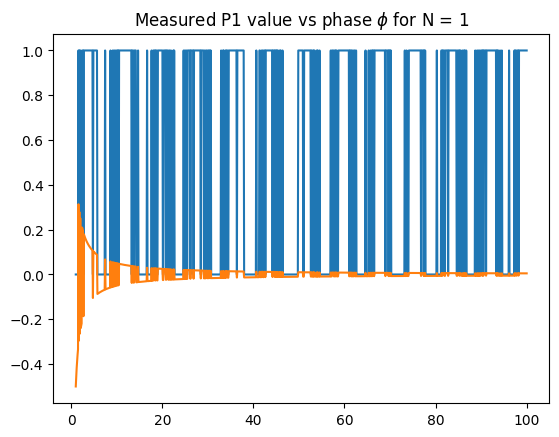

Best t for N = 10 is 1.2972972972972974


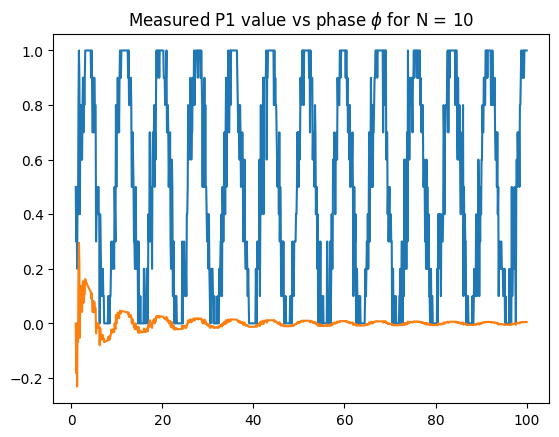

Best t for N = 100 is 1.6936936936936937


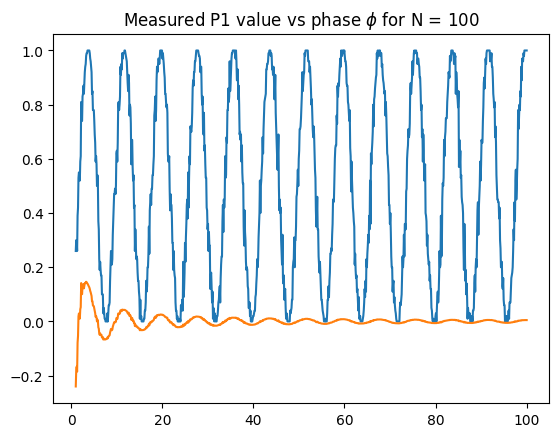

Best t for N = 1000 is 1.7927927927927927


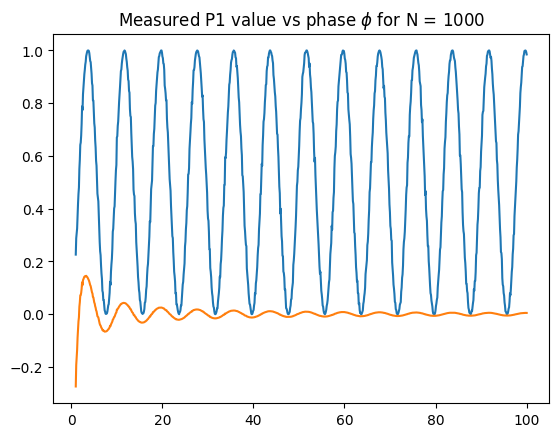

In [71]:
for N in [1, 10, 100, 1000]:
    t_w = np.linspace(1, 100, 1000)
    
    # First, find the best t by sampling around 2
    best_t = 0
    for t in t_w:
        true_p1 = P1(t, Omega, delta)
        p1_val = np.sum(np.random.binomial(1, true_p1, N)) / N
        if p1_val >= 0.5:
            best_t = t
            break
    print("Best t for N = {} is {}".format(N, best_t))

    # Now, lets plot our results relative to the strengh of the field phi
    gamma = 1
    phis = np.linspace(-1, 1, 100)

    measured_p1 = []
    phases = []
    for t in t_w:
        true_p1 = P1(t, Omega, delta)
        p1_val = np.sum(np.random.binomial(1, true_p1, N)) / N

        phi = (p1_val - 0.5) / (gamma * t)
        phase = gamma * phi * t
        measured_p1.append(p1_val)
        phases.append(phi)


    plt.plot(t_w, measured_p1)
    plt.plot(t_w, phases)
    plt.title("Measured P1 value vs phase $\phi$ for N = {}".format(N))
    plt.show()

# 4)

# 4.A)

In [17]:
def H_0(n, t, alpha, omega):
    return (-1.j * omega * (displace(n, alpha) + 0.5 * identity(n)) * t).expm()

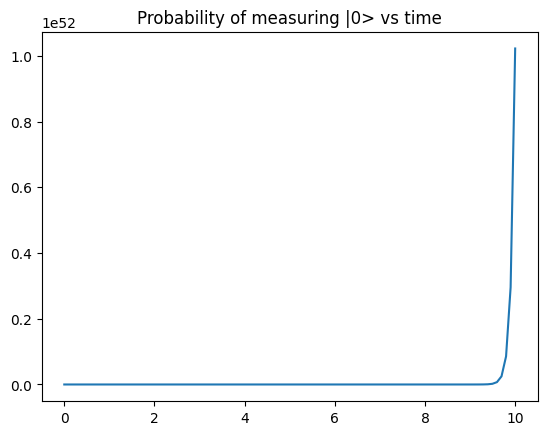

In [18]:
n = 5
alpha = 1
omega = 2 * np.pi

t_vals = np.linspace(0, 10, 100)
evolved_states = []
probs = []
for t in t_vals:
    state = H_0(n, t, alpha, omega) * coherent(n, alpha)
    state_p1_prob = np.abs((fock(n,0).dag() * state * fock(n,0))[0,0])**2

    evolved_states.append(state)
    probs.append(state_p1_prob)

plt.plot(t_vals, probs)
plt.title("Probability of measuring |0> vs time")
plt.show()

## 3.B)

In [19]:
def x(t, m, A, omega, phi):
    return np.sqrt(m * omega / 2) * A * np.cos(omega * t + phi)

def p(t, m, A, omega, phi):
    return -A **2 * omega * np.sin(omega * t + phi) / np.sqrt(2 * m * omega)